In [118]:
import pandas as pd
merged_df = pd.read_csv('C:/Users/tnfus/Downloads/open/train/2018_train_정보_segment.csv', encoding='euc-kr')

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTEENN
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1. 복사본 생성 + 결측치 제거
df = merged_df.copy().dropna()

# 2. LabelEncoder: Segment A~E 포함 전체에 대해 인코딩
label_encoder = LabelEncoder()
df['Segment'] = label_encoder.fit_transform(df['Segment'])

# 3. 범주형 변수 인코딩
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 4. X, y 분리
X = df.drop(columns=['Segment'])
y = df['Segment']

# 5. 수치형 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler(copy=False)
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 6. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 7. SMOTEENN 적용
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# 8. 모델 정의
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000)

# 9. VotingClassifier 구성
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft',
    n_jobs=-1
)

# 10. 학습 및 예측
voting_model.fit(X_train_resampled, y_train_resampled)
y_pred = voting_model.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# 11. 평가 결과 출력
print("\n[VotingClassifier 앙상블 평가 결과]")
print(f"정확도: {accuracy_score(y_test_labels, y_pred_labels) * 100:.2f}%")
print("분류 보고서:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

f1_per_class = f1_score(y_test_labels, y_pred_labels, average=None, zero_division=0)
class_names = label_encoder.classes_
print("클래스별 F1-score:")
for name, score in zip(class_names, f1_per_class):
    print(f"{name}: {score:.4f}")

# 12. 변수 중요도 시각화 (트리 기반 모델만)
print("\n[트리 기반 모델 Feature Importance]")
for name, model in [('XGBoost', xgb_model), ('RandomForest', rf_model)]:
    if hasattr(model, 'feature_importances_'):
        model.fit(X_train_resampled, y_train_resampled)
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance ({name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()



[VotingClassifier 앙상블 평가 결과]
정확도: 80.08%
분류 보고서:
              precision    recall  f1-score   support

           A       0.27      0.38      0.32        16
           B       0.00      0.00      0.00         2
           C       0.60      0.70      0.65      2127
           D       0.41      0.75      0.53      5821
           E       0.97      0.82      0.89     32034

    accuracy                           0.80     40000
   macro avg       0.45      0.53      0.48     40000
weighted avg       0.87      0.80      0.82     40000

클래스별 F1-score:
A: 0.3158
B: 0.0000
C: 0.6454
D: 0.5328
E: 0.8877

[트리 기반 모델 Feature Importance]


C:\Users\tnfus\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:51:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[XGBoost 평가 결과 - 최적 하이퍼파라미터 적용 모델]
정확도: 82.45%
분류 보고서:
              precision    recall  f1-score   support

           A       0.39      0.34      0.37        32
           B       0.00      0.00      0.00         5
           C       0.60      0.68      0.64      4253
           D       0.46      0.73      0.56     11642
           E       0.96      0.85      0.91     64068

    accuracy                           0.82     80000
   macro avg       0.48      0.52      0.49     80000
weighted avg       0.87      0.82      0.84     80000

클래스별 F1-score:
A: 0.3667
B: 0.0000
C: 0.6355
D: 0.5593
E: 0.9052


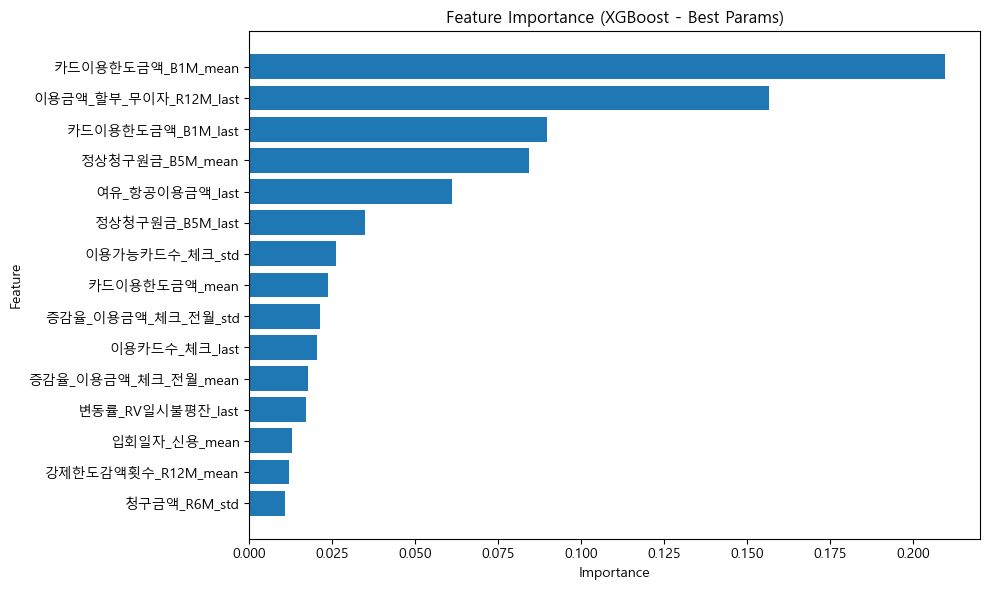

In [119]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTEENN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 복사본 생성 + 결측치 제거
df = merged_df.copy().dropna()

# 2. LabelEncoder: Segment A~E 포함 전체에 대해 인코딩
label_encoder = LabelEncoder()
df['Segment'] = label_encoder.fit_transform(df['Segment'])

# 3. 범주형 변수 인코딩
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 4. X, y 분리
X = df.drop(columns=['Segment'])
y = df['Segment']

# 5. 수치형 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler(copy=False)
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 6. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. SMOTEENN 적용
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# 8. 최적 하이퍼파라미터로 모델 정의
best_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=6,
    n_estimators=200,
    subsample=0.8
)

best_model.fit(X_train_resampled, y_train_resampled)

# 9. 예측 및 평가
y_pred = best_model.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\n[XGBoost 평가 결과 - 최적 하이퍼파라미터 적용 모델]")
print(f"정확도: {accuracy_score(y_test_labels, y_pred_labels) * 100:.2f}%")
print("분류 보고서:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

f1_per_class = f1_score(y_test_labels, y_pred_labels, average=None, zero_division=0)
class_names = label_encoder.classes_
print("클래스별 F1-score:")
for name, score in zip(class_names, f1_per_class):
    print(f"{name}: {score:.4f}")

# 10. 변수 중요도 시각화
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost - Best Params)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

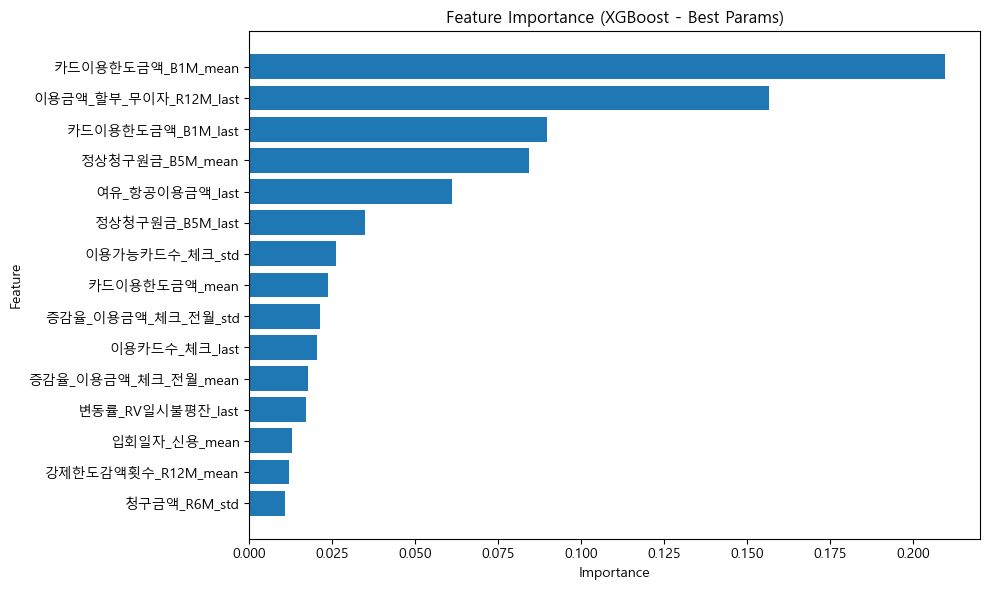

In [3]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 10. 변수 중요도 시각화
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost - Best Params)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [40]:
# 변수 중요도 0.01 이상으로 1차 필터링
filtered_features = feature_importance[feature_importance['Importance'] >= 0.01]

# 누적 중요도 95% 이하로 2차 필터링
filtered_features['Cumulative'] = filtered_features['Importance'].cumsum()
selected_features = filtered_features[filtered_features['Cumulative'] <= 0.95]['Feature'].tolist()

print("최종 선택된 변수 목록:")
print(selected_features)

최종 선택된 변수 목록:
['카드이용한도금액_B1M_mean', '이용금액_할부_무이자_R12M_last', '카드이용한도금액_B1M_last', '정상청구원금_B5M_mean', '여유_항공이용금액_last', '정상청구원금_B5M_last', '이용가능카드수_체크_std', '카드이용한도금액_mean', '증감율_이용금액_체크_전월_std', '이용카드수_체크_last', '증감율_이용금액_체크_전월_mean', '변동률_RV일시불평잔_last', '입회일자_신용_mean', '강제한도감액횟수_R12M_mean', '청구금액_R6M_std']


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10396\3926002553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features['Cumulative'] = filtered_features['Importance'].cumsum()


In [46]:
from sklearn.metrics import f1_score, precision_score, recall_score

# 직접 계산한 F1-score (전체 평균)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# 클래스별 F1-score
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"F1-score (Macro Average): {f1_macro:.4f}")
print(f"F1-score (Weighted Average): {f1_weighted:.4f}")
print("클래스별 F1-score:")
for idx, score in enumerate(f1_per_class):
    print(f"Class {idx}: {score:.4f}")

F1-score (Macro Average): 0.4934
F1-score (Weighted Average): 0.8403
클래스별 F1-score:
Class 0: 0.3667
Class 1: 0.0000
Class 2: 0.6355
Class 3: 0.5593
Class 4: 0.9052


In [75]:
import pyarrow.parquet as pq

df1 = pq.read_table('C:/Users/tnfus/Downloads/open/test/1.회원정보/201812_test_회원정보.parquet').to_pandas()
df2 = pq.read_table('C:/Users/tnfus/Downloads/open/test/2.신용정보/201812_test_신용정보.parquet').to_pandas()
df3 = pq.read_table('C:/Users/tnfus/Downloads/open/test/3.승인매출정보/201812_test_승인매출정보.parquet').to_pandas()
df4 = pq.read_table('C:/Users/tnfus/Downloads/open/test/4.청구입금정보/201812_test_청구정보.parquet').to_pandas()
df6 = pq.read_table('C:/Users/tnfus/Downloads/open/test/6.채널정보/201812_test_채널정보.parquet').to_pandas()
df7 = pq.read_table('C:/Users/tnfus/Downloads/open/test/7.마케팅정보/201812_test_마케팅정보.parquet').to_pandas()
df8 = pq.read_table('C:/Users/tnfus/Downloads/open/test/8.성과정보/201812_test_성과정보.parquet').to_pandas()

In [76]:
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()
df4.columns = df4.columns.str.strip()
df6.columns = df6.columns.str.strip()
df7.columns = df7.columns.str.strip()
df8.columns = df8.columns.str.strip()


In [77]:
df1 = df1[['ID','_1순위카드이용금액', '이용카드수_신용_가족', '이용금액_R3M_신용체크', '회원여부_이용가능_카드론', '유효카드수_신용', 
           '동의여부_한도증액안내', '입회일자_신용', '이용거절여부_카드론', '거주시도명', '유효카드수_체크', '_2순위신용체크구분', 
           '소지카드수_이용가능_신용', '이용카드수_체크', '수신거부여부_DM', '최종탈회후경과월', '입회경과개월수_신용', '이용금액_R3M_신용', 
           '이용가능카드수_신용', '이용가능카드수_체크', '_2순위카드이용건수', '마케팅동의여부', '연령', '소지카드수_유효_신용', '수신거부여부_메일', 
           '카드신청건수', '남녀구분코드', '유효카드수_신용_가족', '가입통신회사코드', 'Life_Stage', '이용여부_3M_해외겸용_신용_본인', 
           '보유여부_해외겸용_본인']]
df2 = df2[['ID','CA한도금액', 'RV전환가능여부', '카드이용한도금액', '상향가능CA한도금액', '카드이용한도금액_B1M', 
           '카드이용한도금액_B2M', '강제한도감액금액_R12M', '일시불ONLY전환가능여부', '한도증액금액_R12M', 'RV신청일자', '한도증액횟수_R12M', 
           '강제한도감액횟수_R12M', 'CA이자율_할인전', 'RV현금서비스이자율_할인전', 'RV약정청구율', '월상환론한도금액', 'rv최초시작후경과일', 
           'RV일시불이자율_할인전', '상향가능한도금액', 'ID', 'RV최소결제비율', '강제한도감액후경과월', '최초한도금액', '월상환론상향가능한도금액', 
           '카드론동의여부']]
df3 = df3[['ID','이용금액_할부_무이자_B0M', '건수_할부전환_R6M', '이용금액_할부_무이자_R12M', '정상입금원금_B5M', '이용건수_선결제_R3M', 
           '이용건수_할부_유이자_R6M', '정상청구원금_B5M', '이용개월수_결제일_R6M', '이용건수_부분무이자_R3M', '여유_항공이용금액', 
           '이용금액_페이_온라인_B0M', '정상입금원금_B2M', '이용건수_선결제_R6M', '할부건수_무이자_3M_R12M']]
df4 = df4[['ID','마일_이용포인트_R12M', '청구금액_R6M', '선결제건수_R6M', '청구금액_R3M', '포인트_마일리지_건별_B0M', '상환개월수_결제일_R6M', 
           '마일_적립포인트_R3M', '포인트_마일리지_월적립_R3M', '마일_잔여포인트_B0M', '포인트_적립포인트_R3M', '대표결제일', 
           '포인트_마일리지_월적립_B0M', '청구금액_B0', '마일_적립포인트_R12M', '할인건수_R3M', '포인트_이용포인트_R12M', 
           '대표청구서수령지구분코드', '할인금액_B0M', '할인금액_R3M', '연체건수_R3M', '상환개월수_결제일_R3M', '혜택수혜금액', 
           '할인금액_청구서_B0M', '선결제건수_R3M', '대표청구지고객주소구분코드', '포인트_포인트_건별_R3M', '포인트_적립포인트_R12M', 
           '마일_이용포인트_R3M']]
df6 = df6[['ID','방문일수_모바일웹_R6M', '인입횟수_IB_B0M', '홈페이지_금융건수_R6M', '방문후경과월_PC_R6M', '방문일수_PC_B0M', 'IB문의건수_선결제_R6M', 
           'OS구분코드', '방문후경과월_앱_R6M', '불만제기후경과월_R12M', '이용메뉴건수_IB_B0M', '상담건수_B0M', '방문횟수_PC_R6M', 
           '방문일수_PC_R6M', '당사멤버쉽_방문월수_R6M', '당사멤버쉽_방문횟수_R6M', 'IB문의건수_카드발급_R6M', '방문월수_앱_R6M', 'IB문의건수_CA_R6M', 
           'IB문의건수_결제_R6M', 'IB문의건수_사용승인내역_R6M', '인입일수_IB_B0M', '방문월수_PC_R6M', '인입월수_IB_R6M', 
           '방문횟수_PC_B0M', '방문일수_앱_B0M', '인입후경과월_IB_R6M', '인입횟수_ARS_R6M', '인입월수_ARS_R6M', '상담건수_R6M', '방문횟수_모바일웹_R6M', 
           'IB문의건수_분실도난_R6M', 'IB문의건수_선결제_B0M', '홈페이지_금융건수_R3M', '인입일수_ARS_B0M']]
df7 = df7[['ID','컨택건수_보험_TM_B0M', '컨택건수_보험_TM_R6M', '컨택건수_이용유도_청구서_B0M', '컨택건수_이용유도_인터넷_B0M', 
           '컨택건수_이용유도_EM_R6M', '컨택건수_이용유도_EM_B0M', '컨택건수_이용유도_LMS_B0M', '컨택건수_이용유도_LMS_R6M', 
           '컨택건수_카드론_TM_R6M', '컨택건수_이용유도_TM_R6M', '컨택건수_이용유도_인터넷_R6M', '캠페인접촉일수_R12M', '컨택건수_카드론_EM_R6M', 
           '컨택건수_이용유도_청구서_R6M', '캠페인접촉건수_R12M', '컨택건수_채권_R6M', '컨택건수_CA_청구서_R6M']]
df8 = df8[['ID','잔액_신판ca최대한도소진율_r6m', '증감율_이용건수_할부_전월', '잔액_신판ca평균한도소진율_r3m', '변동률_잔액_CA_B1M', 
           '증감율_이용금액_신판_분기', '잔액_신판ca최대한도소진율_r3m', '증감율_이용금액_일시불_전월', '변동률_RV일시불평잔', '변동률_일시불평잔', 
           '혜택수혜율_B0M', '증감율_이용금액_할부_분기', '증감율_이용건수_할부_분기', '증감율_이용건수_체크_분기', '증감율_이용금액_신판_전월', 
            '증감율_이용금액_CA_분기', '증감율_이용금액_할부_전월', '잔액_신판평균한도소진율_r6m', '증감율_이용건수_CA_전월', '혜택수혜율_R3M', 
           '잔액_신판평균한도소진율_r3m', '증감율_이용금액_체크_분기', '증감율_이용건수_신판_분기', '증감율_이용금액_체크_전월', 
           '잔액_신판최대한도소진율_r3m', '잔액_신판ca평균한도소진율_r6m', '증감율_이용금액_신용_분기', '증감율_이용건수_CA_분기', '변동률_잔액_B1M', 
           '변동률_CA평잔', '증감율_이용건수_체크_전월', '증감율_이용금액_카드론_분기', '증감율_이용건수_신용_분기', '증감율_이용건수_일시불_분기',
           '증감율_이용금액_CA_전월']]

In [78]:
# 각 데이터프레임에서 'ID' 중복 확인
for i, df in enumerate([df1, df2, df3, df4, df6, df7], start=1):
    print(f"df{i} 컬럼 목록: {df.columns}")

# 중복된 'ID' 열 제거 (첫 번째 'ID'만 남김)
def remove_duplicate_id(df):
    if df.columns.duplicated().sum() > 0:  # 중복 컬럼이 있는 경우
        df = df.loc[:, ~df.columns.duplicated()]
    return df

# 중복 'ID' 컬럼 제거 적용
df1 = remove_duplicate_id(df1)
df2 = remove_duplicate_id(df2)
df3 = remove_duplicate_id(df3)
df4 = remove_duplicate_id(df4)
df6 = remove_duplicate_id(df6)
df7 = remove_duplicate_id(df7)

# 병합
df12 = pd.merge(df1, df2, on='ID', how='outer')
df34 = pd.merge(df3, df4, on='ID', how='outer')
df67 = pd.merge(df6, df7, on='ID', how='outer')

df1 컬럼 목록: Index(['ID', '_1순위카드이용금액', '이용카드수_신용_가족', '이용금액_R3M_신용체크', '회원여부_이용가능_카드론',
       '유효카드수_신용', '동의여부_한도증액안내', '입회일자_신용', '이용거절여부_카드론', '거주시도명', '유효카드수_체크',
       '_2순위신용체크구분', '소지카드수_이용가능_신용', '이용카드수_체크', '수신거부여부_DM', '최종탈회후경과월',
       '입회경과개월수_신용', '이용금액_R3M_신용', '이용가능카드수_신용', '이용가능카드수_체크', '_2순위카드이용건수',
       '마케팅동의여부', '연령', '소지카드수_유효_신용', '수신거부여부_메일', '카드신청건수', '남녀구분코드',
       '유효카드수_신용_가족', '가입통신회사코드', 'Life_Stage', '이용여부_3M_해외겸용_신용_본인',
       '보유여부_해외겸용_본인'],
      dtype='object')
df2 컬럼 목록: Index(['ID', 'CA한도금액', 'RV전환가능여부', '카드이용한도금액', '상향가능CA한도금액', '카드이용한도금액_B1M',
       '카드이용한도금액_B2M', '강제한도감액금액_R12M', '일시불ONLY전환가능여부', '한도증액금액_R12M',
       'RV신청일자', '한도증액횟수_R12M', '강제한도감액횟수_R12M', 'CA이자율_할인전', 'RV현금서비스이자율_할인전',
       'RV약정청구율', '월상환론한도금액', 'rv최초시작후경과일', 'RV일시불이자율_할인전', '상향가능한도금액', 'ID',
       'RV최소결제비율', '강제한도감액후경과월', '최초한도금액', '월상환론상향가능한도금액', '카드론동의여부'],
      dtype='object')
df3 컬럼 목록: Index(['ID', '이용금액_할부_무이자_B0M', '건수_할부전환_R6M', '이용금액_할부_무이자_R12M',
   

In [79]:
df1234 = pd.merge(df12, df34, on='ID', how='outer')
df678 = pd.merge(df67, df8, on='ID', how='outer')

In [80]:
df_1812 = pd.merge(df1234, df678, on='ID', how='outer')

In [81]:
df_1812.to_csv('C:/Users/tnfus/Downloads/open/test/201812_test_정보_merged.csv', index=False, encoding='euc-kr')

In [83]:
df1 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201807_test_정보_merged.csv', encoding='euc-kr')
df2 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201808_test_정보_merged.csv', encoding='euc-kr')
df3 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201809_test_정보_merged.csv', encoding='euc-kr')
df4 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201810_test_정보_merged.csv', encoding='euc-kr')
df5 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201811_test_정보_merged.csv', encoding='euc-kr')
df6 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201812_test_정보_merged.csv', encoding='euc-kr')

In [84]:
df11 = df1.loc[:, df1.isnull().sum() == 0]
df21 = df2.loc[:, df2.isnull().sum() == 0]
df31 = df3.loc[:, df3.isnull().sum() == 0]
df41 = df4.loc[:, df4.isnull().sum() == 0]
df51 = df5.loc[:, df5.isnull().sum() == 0]
df61 = df6.loc[:, df6.isnull().sum() == 0]

In [85]:
# 1. 각 데이터프레임의 열 이름을 set으로 변환
cols1 = set(df11.columns)
cols2 = set(df21.columns)
cols3 = set(df31.columns)
cols4 = set(df41.columns)
cols5 = set(df51.columns)
cols6 = set(df61.columns)

# 2. 교집합 구하기 (6개에 다 있는 열)
common_columns = cols1 & cols2 & cols3 & cols4 & cols5 & cols6

# 3. 공통 열만 포함한 DataFrame 만들기
df11_common = df11[list(common_columns)]
df21_common = df21[list(common_columns)]
df31_common = df31[list(common_columns)]
df41_common = df41[list(common_columns)]
df51_common = df51[list(common_columns)]
df61_common = df61[list(common_columns)]

In [86]:
df7 = df11_common
df8 = df21_common
df9 = df31_common
df10 = df41_common
df11 = df51_common
df12 = df61_common

In [87]:
import pandas as pd

# 1. 6개월치 데이터 결합
full_df = pd.concat([df11, df21, df31, df41, df51, df61], ignore_index=True)

# 2. 사용할 변수 리스트 (7월 분석 기준 중요 변수)
selected_vars = [
    '할부건수_무이자_3M_R12M', '카드이용한도금액', '정상청구원금_B5M', '카드이용한도금액_B1M',
    'IB문의건수_카드발급_R6M', '방문후경과월_PC_R6M', '변동률_RV일시불평잔', '증감율_이용금액_체크_전월',
    '여유_항공이용금액', '이용금액_할부_무이자_R12M', '이용카드수_체크', '마일_적립포인트_R12M',
    '카드이용한도금액_B2M', '강제한도감액횟수_R12M', '이용가능카드수_체크', '잔액_신판ca최대한도소진율_r3m',
    '청구금액_R6M', '입회일자_신용', '유효카드수_신용'
]

# 3. 실제로 존재하는 컬럼만 필터링 (혹시 누락된 게 있을 수도 있으니까 안전하게)
existing_vars = [col for col in selected_vars if col in full_df.columns]

# 4. ID 기준 그룹화
grouped = full_df.groupby('ID')

# 5. 선택된 변수에 대해서만 통계 계산
agg_mean = grouped[existing_vars].mean().add_suffix('_mean')
agg_std  = grouped[existing_vars].std().add_suffix('_std')
agg_last = grouped[existing_vars].last().add_suffix('_last')

# 6. 최종 고객 요약 데이터 생성
customer_summary = pd.concat([agg_mean, agg_std, agg_last], axis=1).reset_index()

In [88]:
customer_summary.to_csv('C:/Users/tnfus/Downloads/open/test/2018_test_정보_merged_1.csv', index = False, encoding='euc-kr')

In [102]:
merged_df = customer_summary

In [90]:
# pandas 옵션 변경해서 열 모두 출력되도록 설정
pd.set_option('display.max_columns', None)

# 그리고 컬럼 출력
print(merged_df.columns.tolist())  # 또는 df.columns.values

pd.reset_option('display.max_columns')

['ID', '할부건수_무이자_3M_R12M_mean', '카드이용한도금액_mean', '정상청구원금_B5M_mean', '카드이용한도금액_B1M_mean', 'IB문의건수_카드발급_R6M_mean', '방문후경과월_PC_R6M_mean', '변동률_RV일시불평잔_mean', '증감율_이용금액_체크_전월_mean', '여유_항공이용금액_mean', '이용금액_할부_무이자_R12M_mean', '이용카드수_체크_mean', '마일_적립포인트_R12M_mean', '카드이용한도금액_B2M_mean', '강제한도감액횟수_R12M_mean', '이용가능카드수_체크_mean', '잔액_신판ca최대한도소진율_r3m_mean', '청구금액_R6M_mean', '입회일자_신용_mean', '유효카드수_신용_mean', '할부건수_무이자_3M_R12M_std', '카드이용한도금액_std', '정상청구원금_B5M_std', '카드이용한도금액_B1M_std', 'IB문의건수_카드발급_R6M_std', '방문후경과월_PC_R6M_std', '변동률_RV일시불평잔_std', '증감율_이용금액_체크_전월_std', '여유_항공이용금액_std', '이용금액_할부_무이자_R12M_std', '이용카드수_체크_std', '마일_적립포인트_R12M_std', '카드이용한도금액_B2M_std', '강제한도감액횟수_R12M_std', '이용가능카드수_체크_std', '잔액_신판ca최대한도소진율_r3m_std', '청구금액_R6M_std', '입회일자_신용_std', '유효카드수_신용_std', '할부건수_무이자_3M_R12M_last', '카드이용한도금액_last', '정상청구원금_B5M_last', '카드이용한도금액_B1M_last', 'IB문의건수_카드발급_R6M_last', '방문후경과월_PC_R6M_last', '변동률_RV일시불평잔_last', '증감율_이용금액_체크_전월_last', '여유_항공이용금액_last', '이용금액_할부_무이자_R12M_last', '이용카드수_체크_last

In [92]:
df111 = pd.read_csv('C:/Users/tnfus/Downloads/open/test/201807_test_정보_merged.csv', encoding='euc-kr')

In [93]:
df111.columns

Index(['ID', '_1순위카드이용금액', '이용카드수_신용_가족', '이용금액_R3M_신용체크', '회원여부_이용가능_카드론',
       '유효카드수_신용', '동의여부_한도증액안내', '입회일자_신용', '이용거절여부_카드론', '거주시도명',
       ...
       '잔액_신판ca평균한도소진율_r6m', '증감율_이용금액_신용_분기', '증감율_이용건수_CA_분기', '변동률_잔액_B1M',
       '변동률_CA평잔', '증감율_이용건수_체크_전월', '증감율_이용금액_카드론_분기', '증감율_이용건수_신용_분기',
       '증감율_이용건수_일시불_분기', '증감율_이용금액_CA_전월'],
      dtype='object', length=183)

In [103]:
df_selected = df111[['ID', '남녀구분코드', '연령']]

In [104]:
df_selected

,ID,남녀구분코드,연령
0,TEST_00000,1,40대
1,TEST_00001,1,60대
2,TEST_00002,1,40대
3,TEST_00003,2,40대
4,TEST_00004,2,40대
...,...,...,...
99995,TEST_99995,2,60대
99996,TEST_99996,1,30대
99997,TEST_99997,2,30대
99998,TEST_99998,1,30대


In [131]:
merged_df1 = pd.merge(df_selected, merged_df1, on='ID', how='outer')

In [132]:
# pandas 옵션 변경해서 열 모두 출력되도록 설정
pd.set_option('display.max_columns', None)

# 그리고 컬럼 출력
print(merged_df1.columns.tolist())  # 또는 df.columns.values

pd.reset_option('display.max_columns')

['ID', '남녀구분코드', '연령', '할부건수_무이자_3M_R12M_mean', '카드이용한도금액_mean', '정상청구원금_B5M_mean', '카드이용한도금액_B1M_mean', 'IB문의건수_카드발급_R6M_mean', '방문후경과월_PC_R6M_mean', '변동률_RV일시불평잔_mean', '증감율_이용금액_체크_전월_mean', '여유_항공이용금액_mean', '이용금액_할부_무이자_R12M_mean', '이용카드수_체크_mean', '마일_적립포인트_R12M_mean', '카드이용한도금액_B2M_mean', '강제한도감액횟수_R12M_mean', '이용가능카드수_체크_mean', '잔액_신판ca최대한도소진율_r3m_mean', '청구금액_R6M_mean', '입회일자_신용_mean', '유효카드수_신용_mean', '할부건수_무이자_3M_R12M_std', '카드이용한도금액_std', '정상청구원금_B5M_std', '카드이용한도금액_B1M_std', 'IB문의건수_카드발급_R6M_std', '방문후경과월_PC_R6M_std', '변동률_RV일시불평잔_std', '증감율_이용금액_체크_전월_std', '여유_항공이용금액_std', '이용금액_할부_무이자_R12M_std', '이용카드수_체크_std', '마일_적립포인트_R12M_std', '카드이용한도금액_B2M_std', '강제한도감액횟수_R12M_std', '이용가능카드수_체크_std', '잔액_신판ca최대한도소진율_r3m_std', '청구금액_R6M_std', '입회일자_신용_std', '유효카드수_신용_std', '할부건수_무이자_3M_R12M_last', '카드이용한도금액_last', '정상청구원금_B5M_last', '카드이용한도금액_B1M_last', 'IB문의건수_카드발급_R6M_last', '방문후경과월_PC_R6M_last', '변동률_RV일시불평잔_last', '증감율_이용금액_체크_전월_last', '여유_항공이용금액_last', '이용금액_할부_무이자_R12M_last'

In [120]:
merged_df1.to_csv('C:/Users/tnfus/Downloads/open/test/2018_test_정보_segment.csv', encoding='euc-kr')

C:\Users\tnfus\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:57:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



[XGBoost 평가 결과 - 최적 하이퍼파라미터 적용 모델]
정확도: 82.33%
분류 보고서:
              precision    recall  f1-score   support

           A       0.39      0.34      0.37        32
           B       0.00      0.00      0.00         5
           C       0.60      0.68      0.64      4253
           D       0.45      0.73      0.56     11642
           E       0.96      0.85      0.90     64068

    accuracy                           0.82     80000
   macro avg       0.48      0.52      0.49     80000
weighted avg       0.87      0.82      0.84     80000

클래스별 F1-score:
A: 0.3667
B: 0.0000
C: 0.6391
D: 0.5582
E: 0.9041


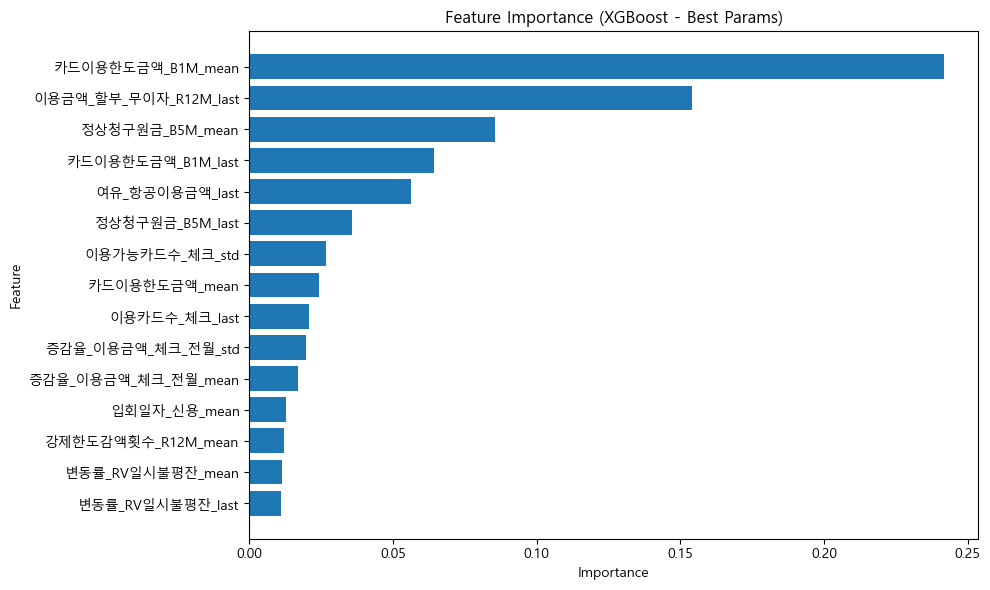

✅ 모델 및 전처리 도구 저장 완료!
✅ Segment 예측 완료 및 저장!


In [135]:
# =============================
# 1. 학습 코드 + 저장
# =============================

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTEENN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 1. 복사본 생성 + 결측치 제거
df = merged_df.copy().dropna()

# 불필요한 인덱스 열 제거
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 연령 전처리: 앞 2글자만 추출해 숫자로 변환
if '연령' in df.columns:
    df['연령'] = df['연령'].astype(str).str[:2].astype(int)

# 2. LabelEncoder: Segment A~E 포함 전체에 대해 인코딩
label_encoder = LabelEncoder()
df['Segment'] = label_encoder.fit_transform(df['Segment'])

# 3. 범주형 변수 인코딩 ('남녀구분코드' 포함)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if '남녀구분코드' not in categorical_cols and '남녀구분코드' in df.columns:
    categorical_cols.append('남녀구분코드')
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 4. X, y 분리
X = df.drop(columns=['Segment'])
y = df['Segment']

# 5. 수치형 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler(copy=False)
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 6. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. SMOTEENN 적용
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# 8. 최적 하이퍼파라미터로 모델 정의
best_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=6,
    n_estimators=200,
    subsample=0.8
)
best_model.fit(X_train_resampled, y_train_resampled)

# 9. 평가
y_pred = best_model.predict(X_test)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("\n[XGBoost 평가 결과 - 최적 하이퍼파라미터 적용 모델]")
print(f"정확도: {accuracy_score(y_test_labels, y_pred_labels) * 100:.2f}%")
print("분류 보고서:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

f1_per_class = f1_score(y_test_labels, y_pred_labels, average=None, zero_division=0)
class_names = label_encoder.classes_
print("클래스별 F1-score:")
for name, score in zip(class_names, f1_per_class):
    print(f"{name}: {score:.4f}")

# 10. 변수 중요도 시각화
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost - Best Params)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 11. 객체 저장
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(best_model, 'xgb_best_model.pkl')
joblib.dump(categorical_cols, 'categorical_cols.pkl')
joblib.dump(numerical_cols, 'numerical_cols.pkl')
print("✅ 모델 및 전처리 도구 저장 완료!")

# =============================
# 2. 예측 코드 (test 데이터 사용)
# =============================

# 예측 대상: merged_df1에 Segment 없음 (빈 열 생성)
df_predict = merged_df1.copy()
df_predict['Segment'] = np.nan

# 불필요한 인덱스 열 제거
if 'Unnamed: 0' in df_predict.columns:
    df_predict = df_predict.drop(columns=['Unnamed: 0'])

# 연령 전처리
if '연령' in df_predict.columns:
    df_predict['연령'] = df_predict['연령'].astype(str).str[:2].astype(int)

# 저장된 객체 불러오기
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')
best_model = joblib.load('xgb_best_model.pkl')
categorical_cols = joblib.load('categorical_cols.pkl')
numerical_cols = joblib.load('numerical_cols.pkl')

# 실제 존재하는 열만 선택해서 전처리
categorical_cols_exist = [col for col in categorical_cols if col in df_predict.columns]
numerical_cols_exist = [col for col in numerical_cols if col in df_predict.columns]

for col in categorical_cols_exist:
    df_predict[col] = LabelEncoder().fit_transform(df_predict[col].astype(str))

# 수치형 스케일링 (존재하는 열만)
df_predict[numerical_cols_exist] = scaler.transform(df_predict[numerical_cols_exist])

# 예측
X_new = df_predict.drop(columns=['Segment'])
pred_encoded = best_model.predict(X_new)
pred_labels = label_encoder.inverse_transform(pred_encoded)

# 결과 저장
df_predict['Predicted_Segment'] = pred_labels
df_predict.to_csv('C:/Users/tnfus/Downloads/open/test/2018_test_정보_segment.csv', index=False, encoding='euc-kr')
print("✅ Segment 예측 완료 및 저장!")




In [137]:
df_predict.columns

Index(['ID', '남녀구분코드', '연령', '할부건수_무이자_3M_R12M_mean', '카드이용한도금액_mean',
       '정상청구원금_B5M_mean', '카드이용한도금액_B1M_mean', 'IB문의건수_카드발급_R6M_mean',
       '방문후경과월_PC_R6M_mean', '변동률_RV일시불평잔_mean', '증감율_이용금액_체크_전월_mean',
       '여유_항공이용금액_mean', '이용금액_할부_무이자_R12M_mean', '이용카드수_체크_mean',
       '마일_적립포인트_R12M_mean', '카드이용한도금액_B2M_mean', '강제한도감액횟수_R12M_mean',
       '이용가능카드수_체크_mean', '잔액_신판ca최대한도소진율_r3m_mean', '청구금액_R6M_mean',
       '입회일자_신용_mean', '유효카드수_신용_mean', '할부건수_무이자_3M_R12M_std', '카드이용한도금액_std',
       '정상청구원금_B5M_std', '카드이용한도금액_B1M_std', 'IB문의건수_카드발급_R6M_std',
       '방문후경과월_PC_R6M_std', '변동률_RV일시불평잔_std', '증감율_이용금액_체크_전월_std',
       '여유_항공이용금액_std', '이용금액_할부_무이자_R12M_std', '이용카드수_체크_std',
       '마일_적립포인트_R12M_std', '카드이용한도금액_B2M_std', '강제한도감액횟수_R12M_std',
       '이용가능카드수_체크_std', '잔액_신판ca최대한도소진율_r3m_std', '청구금액_R6M_std',
       '입회일자_신용_std', '유효카드수_신용_std', '할부건수_무이자_3M_R12M_last', '카드이용한도금액_last',
       '정상청구원금_B5M_last', '카드이용한도금액_B1M_last', 'IB문의건수_카드발급_R6M_last',
       '방

In [139]:
df21 = df_predict['Predicted_Segment']

In [141]:
df21.to_csv('C:/Users/tnfus/Downloads/open/test/2018_test_segment.csv', index=False, encoding='euc-kr')